In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# %aimport analysis

In [7]:
conditions = pd.read_csv("conditions.csv")
patients = pd.read_csv("patients.csv")
observations = pd.read_csv("observations.csv")
care_plans = pd.read_csv("careplans.csv")
encounters = pd.read_csv("encounters.csv")
devices = pd.read_csv("devices.csv")
supplies = pd.read_csv('supplies.csv')
procedures = pd.read_csv("procedures.csv")
medications = pd.read_csv("medications.csv")

In [8]:
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()

In [9]:
negative_covid_patient_ids = observations[(observations.CODE == '94531-1') & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()

In [10]:
deceased_patients = patients[patients.DEATHDATE.notna()].Id

In [11]:
completed_isolation_patients = care_plans[(care_plans.CODE == 736376001) & (care_plans.STOP.notna()) & (care_plans.REASONCODE == 840539006)].PATIENT

In [12]:
survivor_ids = np.union1d(completed_isolation_patients, negative_covid_patient_ids)

In [13]:
inpatient_ids = encounters[(encounters.REASONCODE == 840539006) & (encounters.CODE == 1505002)].PATIENT

In [14]:
np.intersect1d(inpatient_ids, survivor_ids).shape

(1522,)

In [15]:
np.intersect1d(inpatient_ids, deceased_patients).shape

(349,)

In [16]:
inpatient_ids.shape

(1867,)

In [17]:
lab_obs = observations[(observations.CODE == '48065-7') | (observations.CODE == '26881-3') | 
                          (observations.CODE == '2276-4') | (observations.CODE == '89579-7') |
                          (observations.CODE == '2532-0') | (observations.CODE == '731-0') |
                          (observations.CODE == '14804-9')
                      ]

In [18]:
covid_conditions = conditions[conditions.CODE == 840539006]

In [19]:
covid_patients = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')

In [20]:
covid_patients['survivor'] = covid_patients.PATIENT.isin(survivor_ids)

In [21]:
covid_patients = covid_patients[['START', 'PATIENT', 'survivor', 'CODE']]

In [22]:
covid_patients_obs = covid_patients.merge(lab_obs, on='PATIENT')
covid_patients_obs['START'] = pd.to_datetime(covid_patients_obs.START)
covid_patients_obs['DATE'] = pd.to_datetime(covid_patients_obs.DATE)
covid_patients_obs['lab_days'] = covid_patients_obs.DATE - covid_patients_obs.START
covid_patients_obs['days'] = covid_patients_obs.lab_days / np.timedelta64(1, 'D')
covid_patients_obs['VALUE'] = pd.to_numeric(covid_patients_obs['VALUE'], errors='coerce')

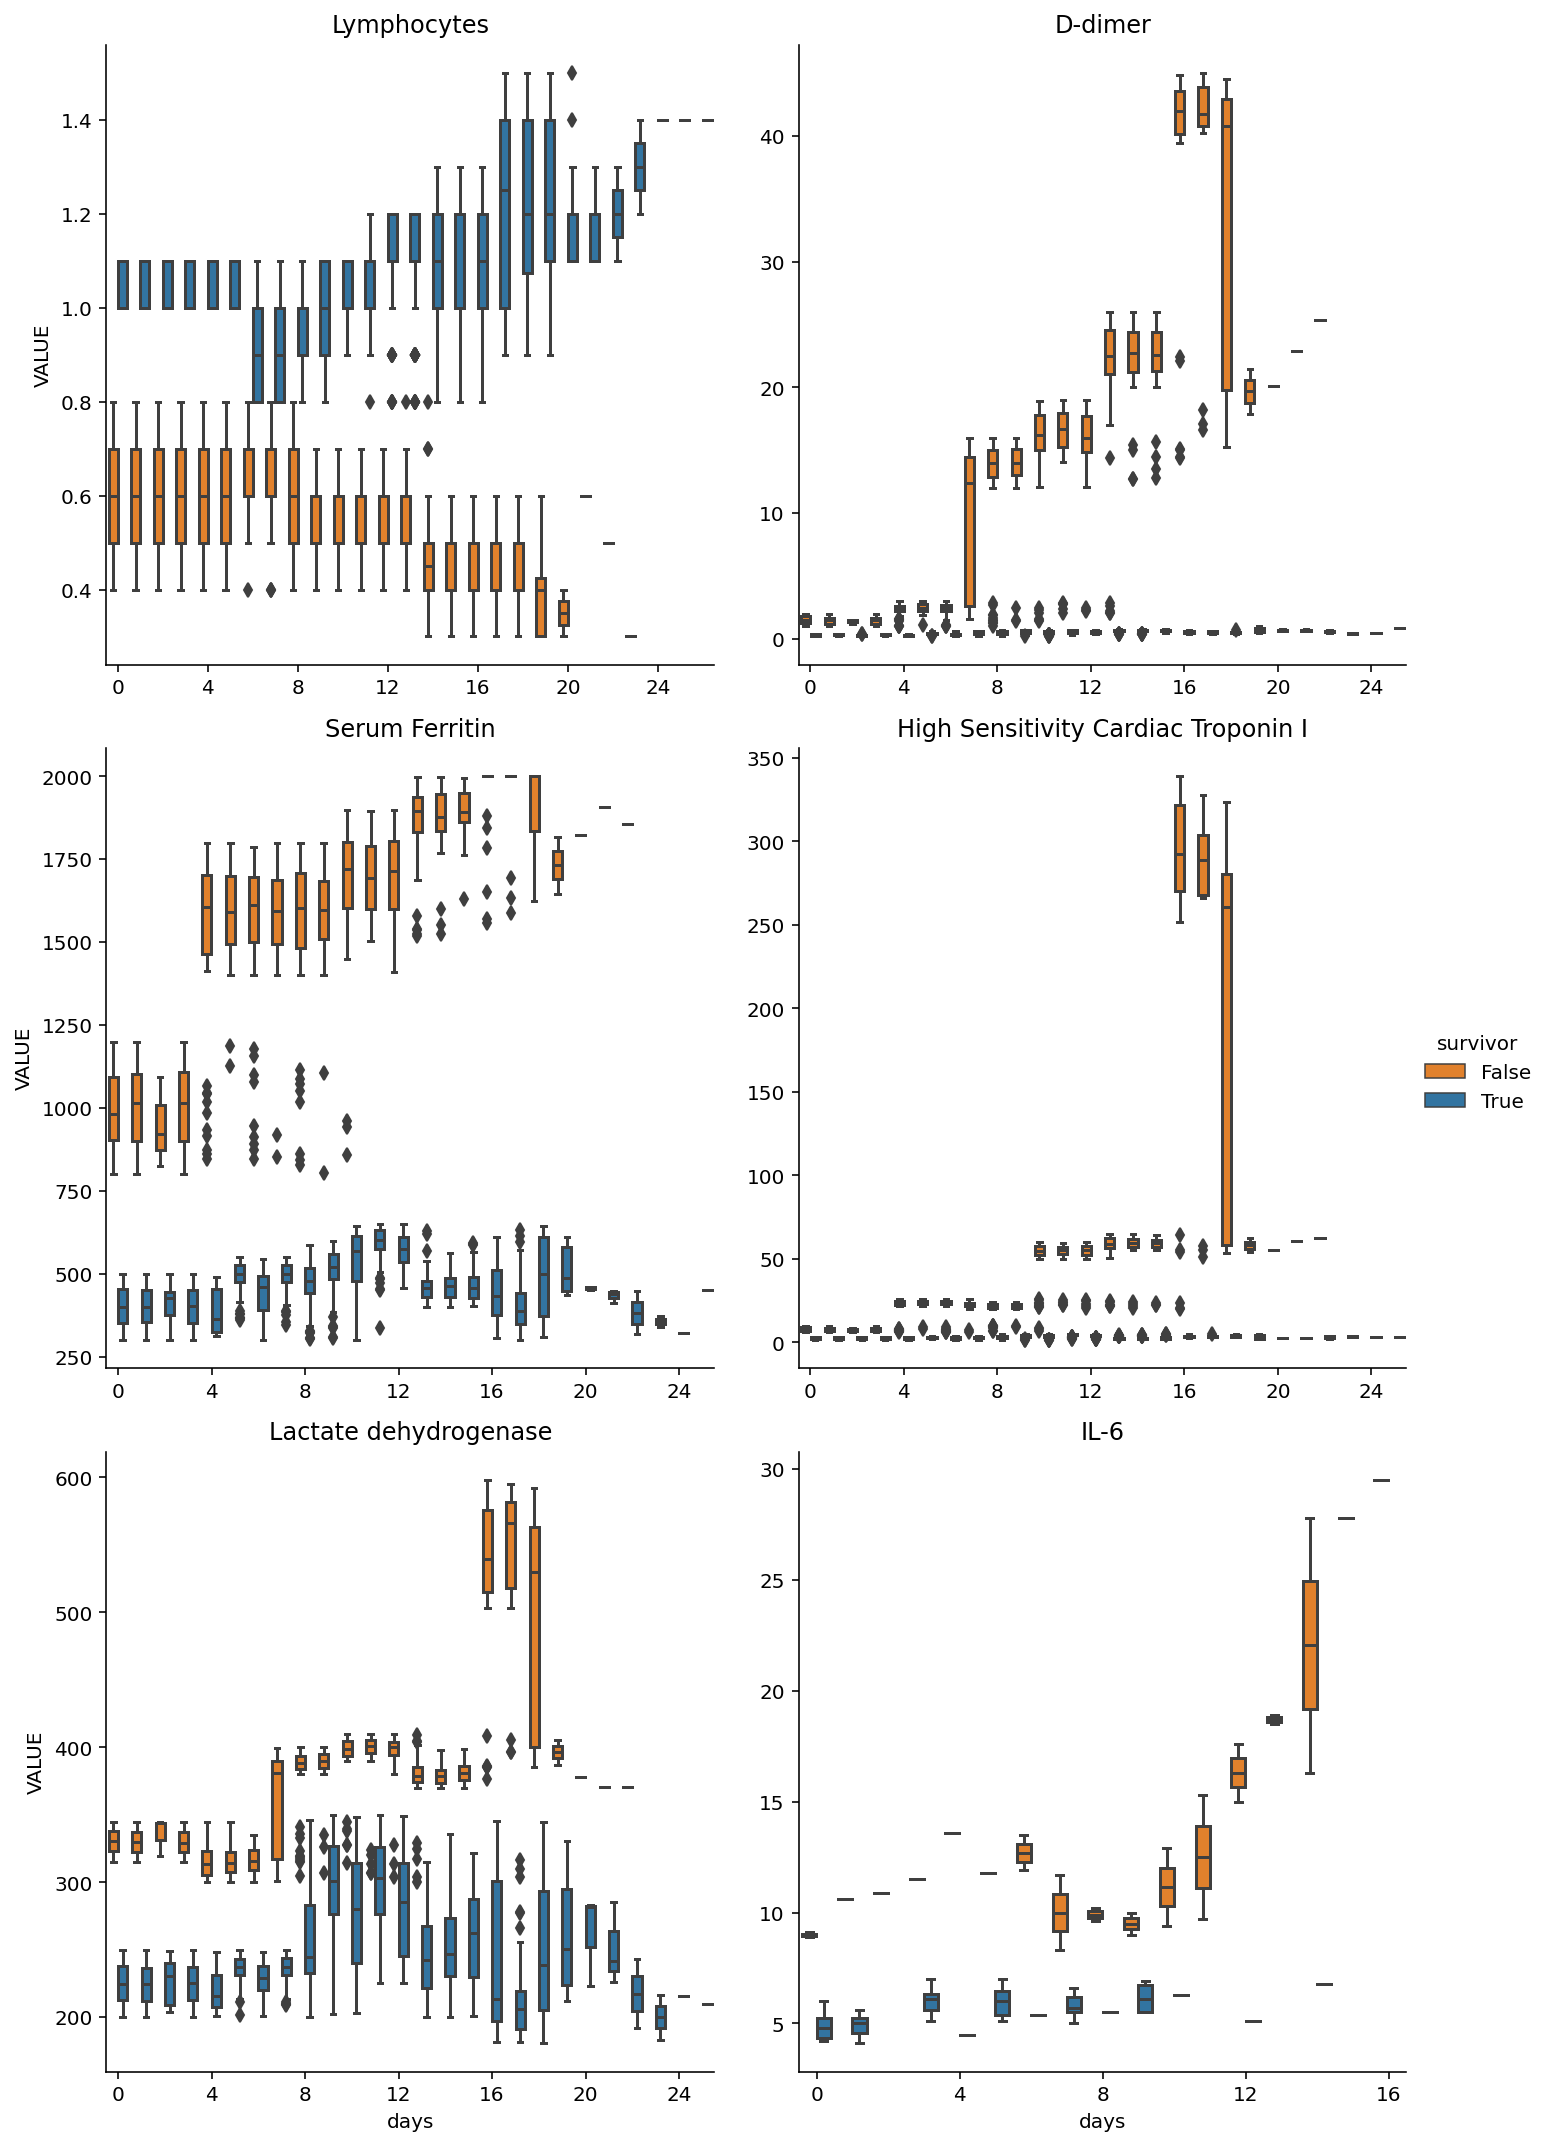

In [23]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="box", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])
        
plt.show()

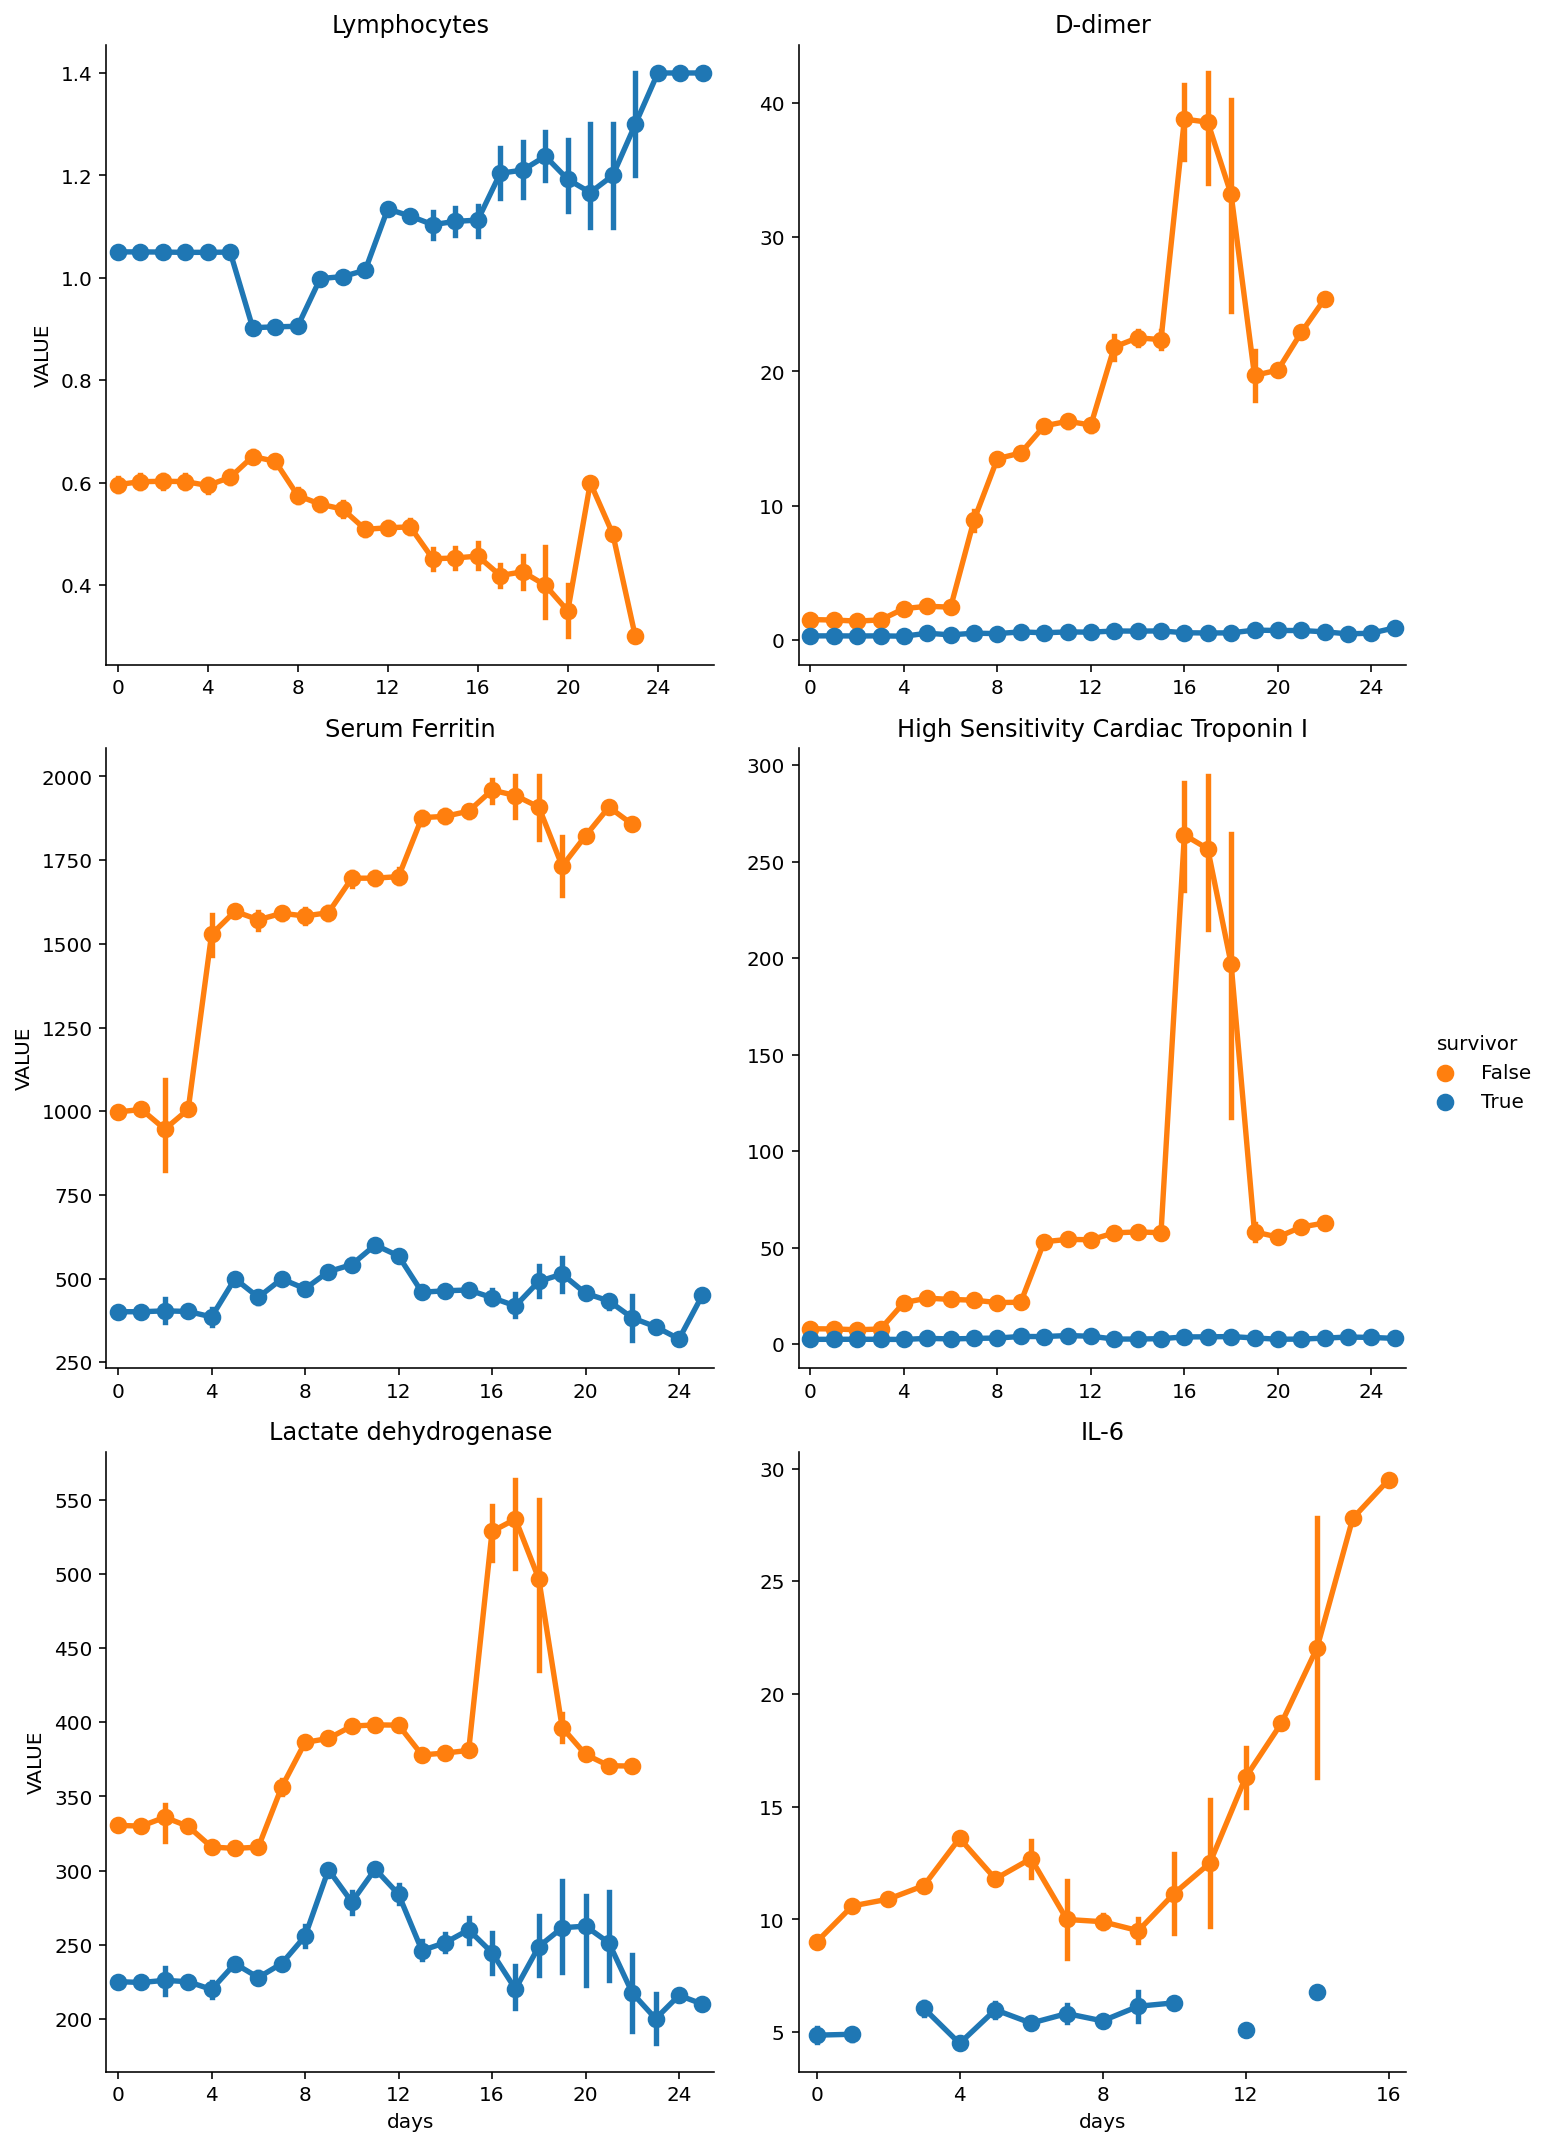

In [24]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="point", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])

plt.show()

In [25]:
cp = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')
isolation_ids = care_plans[(care_plans.CODE == 736376001) & (care_plans.REASONCODE == 840539006)].PATIENT
cp['isolation'] = cp.Id.isin(isolation_ids)
cp['admit'] = cp.Id.isin(inpatient_ids)
cp['recovered'] = cp.Id.isin(survivor_ids)
cp['death'] = cp.DEATHDATE.notna()
icu_ids = encounters[encounters.CODE == 305351004].PATIENT
cp['icu_admit'] = cp.Id.isin(icu_ids)
vent_ids = procedures[procedures.CODE == 26763009].PATIENT
cp['ventilated'] = cp.Id.isin(vent_ids)

In [26]:
hospitalized = (cp.admit == True)
icu = (cp.icu_admit == True)
vent = (cp.ventilated == True)
covid_count = cp.Id.size
row_filters = {'Home Isolation': (cp.isolation == True), 'Hospital Admission': hospitalized, 'ICU Admission': icu,
 'Ventilated': vent, 'Recovered': (cp.recovered == True), 'Death': (cp.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['All Patients'] = cp[row_filter].Id.size / covid_count
    row['Hospitalized'] = cp[row_filter & hospitalized].Id.size / hospitalized.value_counts()[True]
    row['ICU Admitted'] = cp[row_filter & icu].Id.size / icu.value_counts()[True]
    row['Required Ventilation'] = cp[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,All Patients,Hospitalized,ICU Admitted,Required Ventilation
0,Home Isolation,0.795238,0.032673,0.026667,0.024390
1,Hospital Admission,0.211678,1.000000,1.000000,1.000000
2,ICU Admission,0.042517,0.200857,1.000000,1.000000
3,Ventilated,0.032540,0.153723,0.765333,1.000000
4,Recovered,0.960658,0.815212,0.357333,0.163763
5,Death,0.040476,0.186931,0.645333,0.836237


In [27]:
icu_only = cp[cp.icu_admit == True]

vent = (icu_only.ventilated == True)
covid_count = icu_only.Id.size
row_filters = {'Ventilated': vent, 'Recovered': (icu_only.recovered == True), 'Death': (icu_only.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['ICU Admitted'] = icu_only[row_filter].Id.size / covid_count
    row['Required Ventilation'] = icu_only[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,ICU Admitted,Required Ventilation
0,Ventilated,0.765333,1.000000
1,Recovered,0.357333,0.163763
2,Death,0.645333,0.836237


In [28]:
covid_info = cp[['PATIENT', 'recovered', 'death', 'START', 'DEATHDATE', 'BIRTHDATE', 'GENDER', 'admit', 'icu_admit']]


In [29]:
covid_info = covid_info.rename(columns={'START': 'covid_start'})

In [30]:
covid_related_conditions = conditions[pd.to_datetime(conditions.START) > pd.to_datetime('2020-01-20')]

In [31]:
covid_patient_conditions = covid_info.merge(covid_related_conditions, on='PATIENT')

In [33]:
analysis.symptom_table(covid_patient_conditions)

NameError: name 'analysis' is not defined

In [34]:
covid_patient_conditions['start_days'] = (pd.to_datetime(covid_patient_conditions.START) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['end_days'] = (pd.to_datetime(covid_patient_conditions.STOP) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['death_days'] = (pd.to_datetime(covid_patient_conditions.DEATHDATE) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')

In [38]:
covid_info.loc[covid_info.death == True, 'age'] = (pd.to_datetime(covid_info.DEATHDATE) - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

In [39]:
covid_info.loc[covid_info.recovered == True, 'age'] = (datetime.datetime.now() - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

In [40]:
bins = list(range(0, 120, 10))
covid_info['age_range'] = pd.cut(covid_info.age, bins=bins)

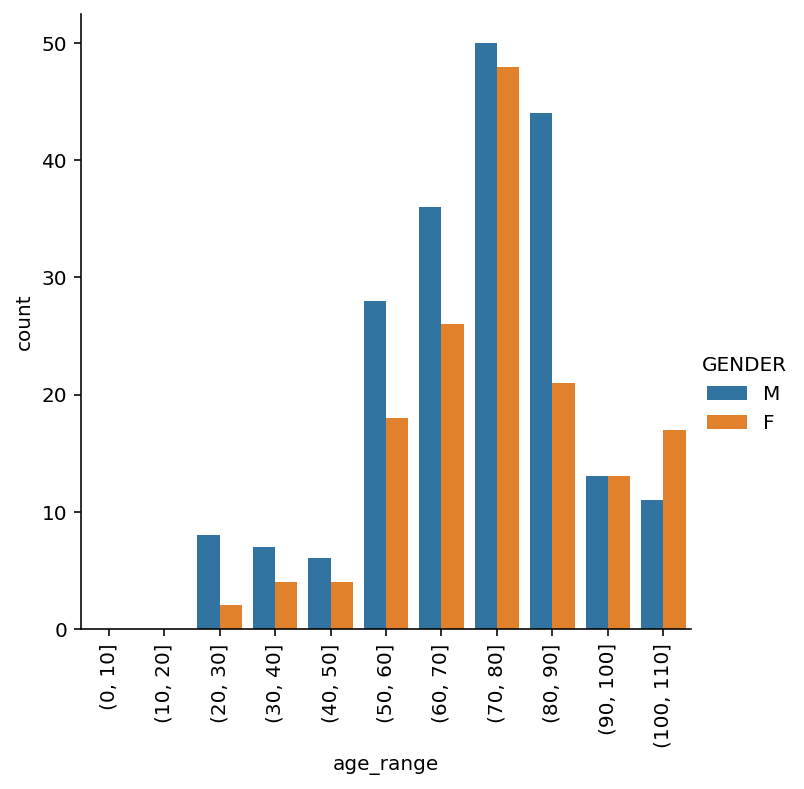

In [41]:
chart = sns.catplot(x="age_range", kind="count", hue="GENDER", data=covid_info[covid_info.death==True]);
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

In [42]:

covid_info[covid_info.death==True].groupby(['age_range', 'GENDER']).count()[['PATIENT']]

PATIENT
age_range  GENDER         
(0, 10]    F             0
           M             0
(10, 20]   F             0
           M             0
(20, 30]   F             2
           M             8
(30, 40]   F             4
           M             7
(40, 50]   F             4
           M             6
(50, 60]   F            18
           M            28
(60, 70]   F            26
           M            36
(70, 80]   F            48
           M            50
(80, 90]   F            21
           M            44
(90, 100]  F            13
           M            13
(100, 110] F            17
           M            11

In [43]:
covid_info[covid_info.death==True].groupby(['age_range']).count()[['PATIENT']]

,PATIENT
age_range,
"(0, 10]",0
"(10, 20]",0
"(20, 30]",10
"(30, 40]",11
"(40, 50]",10
"(50, 60]",46
"(60, 70]",62
"(70, 80]",98
"(80, 90]",65


In [45]:

grouped_supplies = supplies.groupby(['DESCRIPTION', 'DATE']).sum()

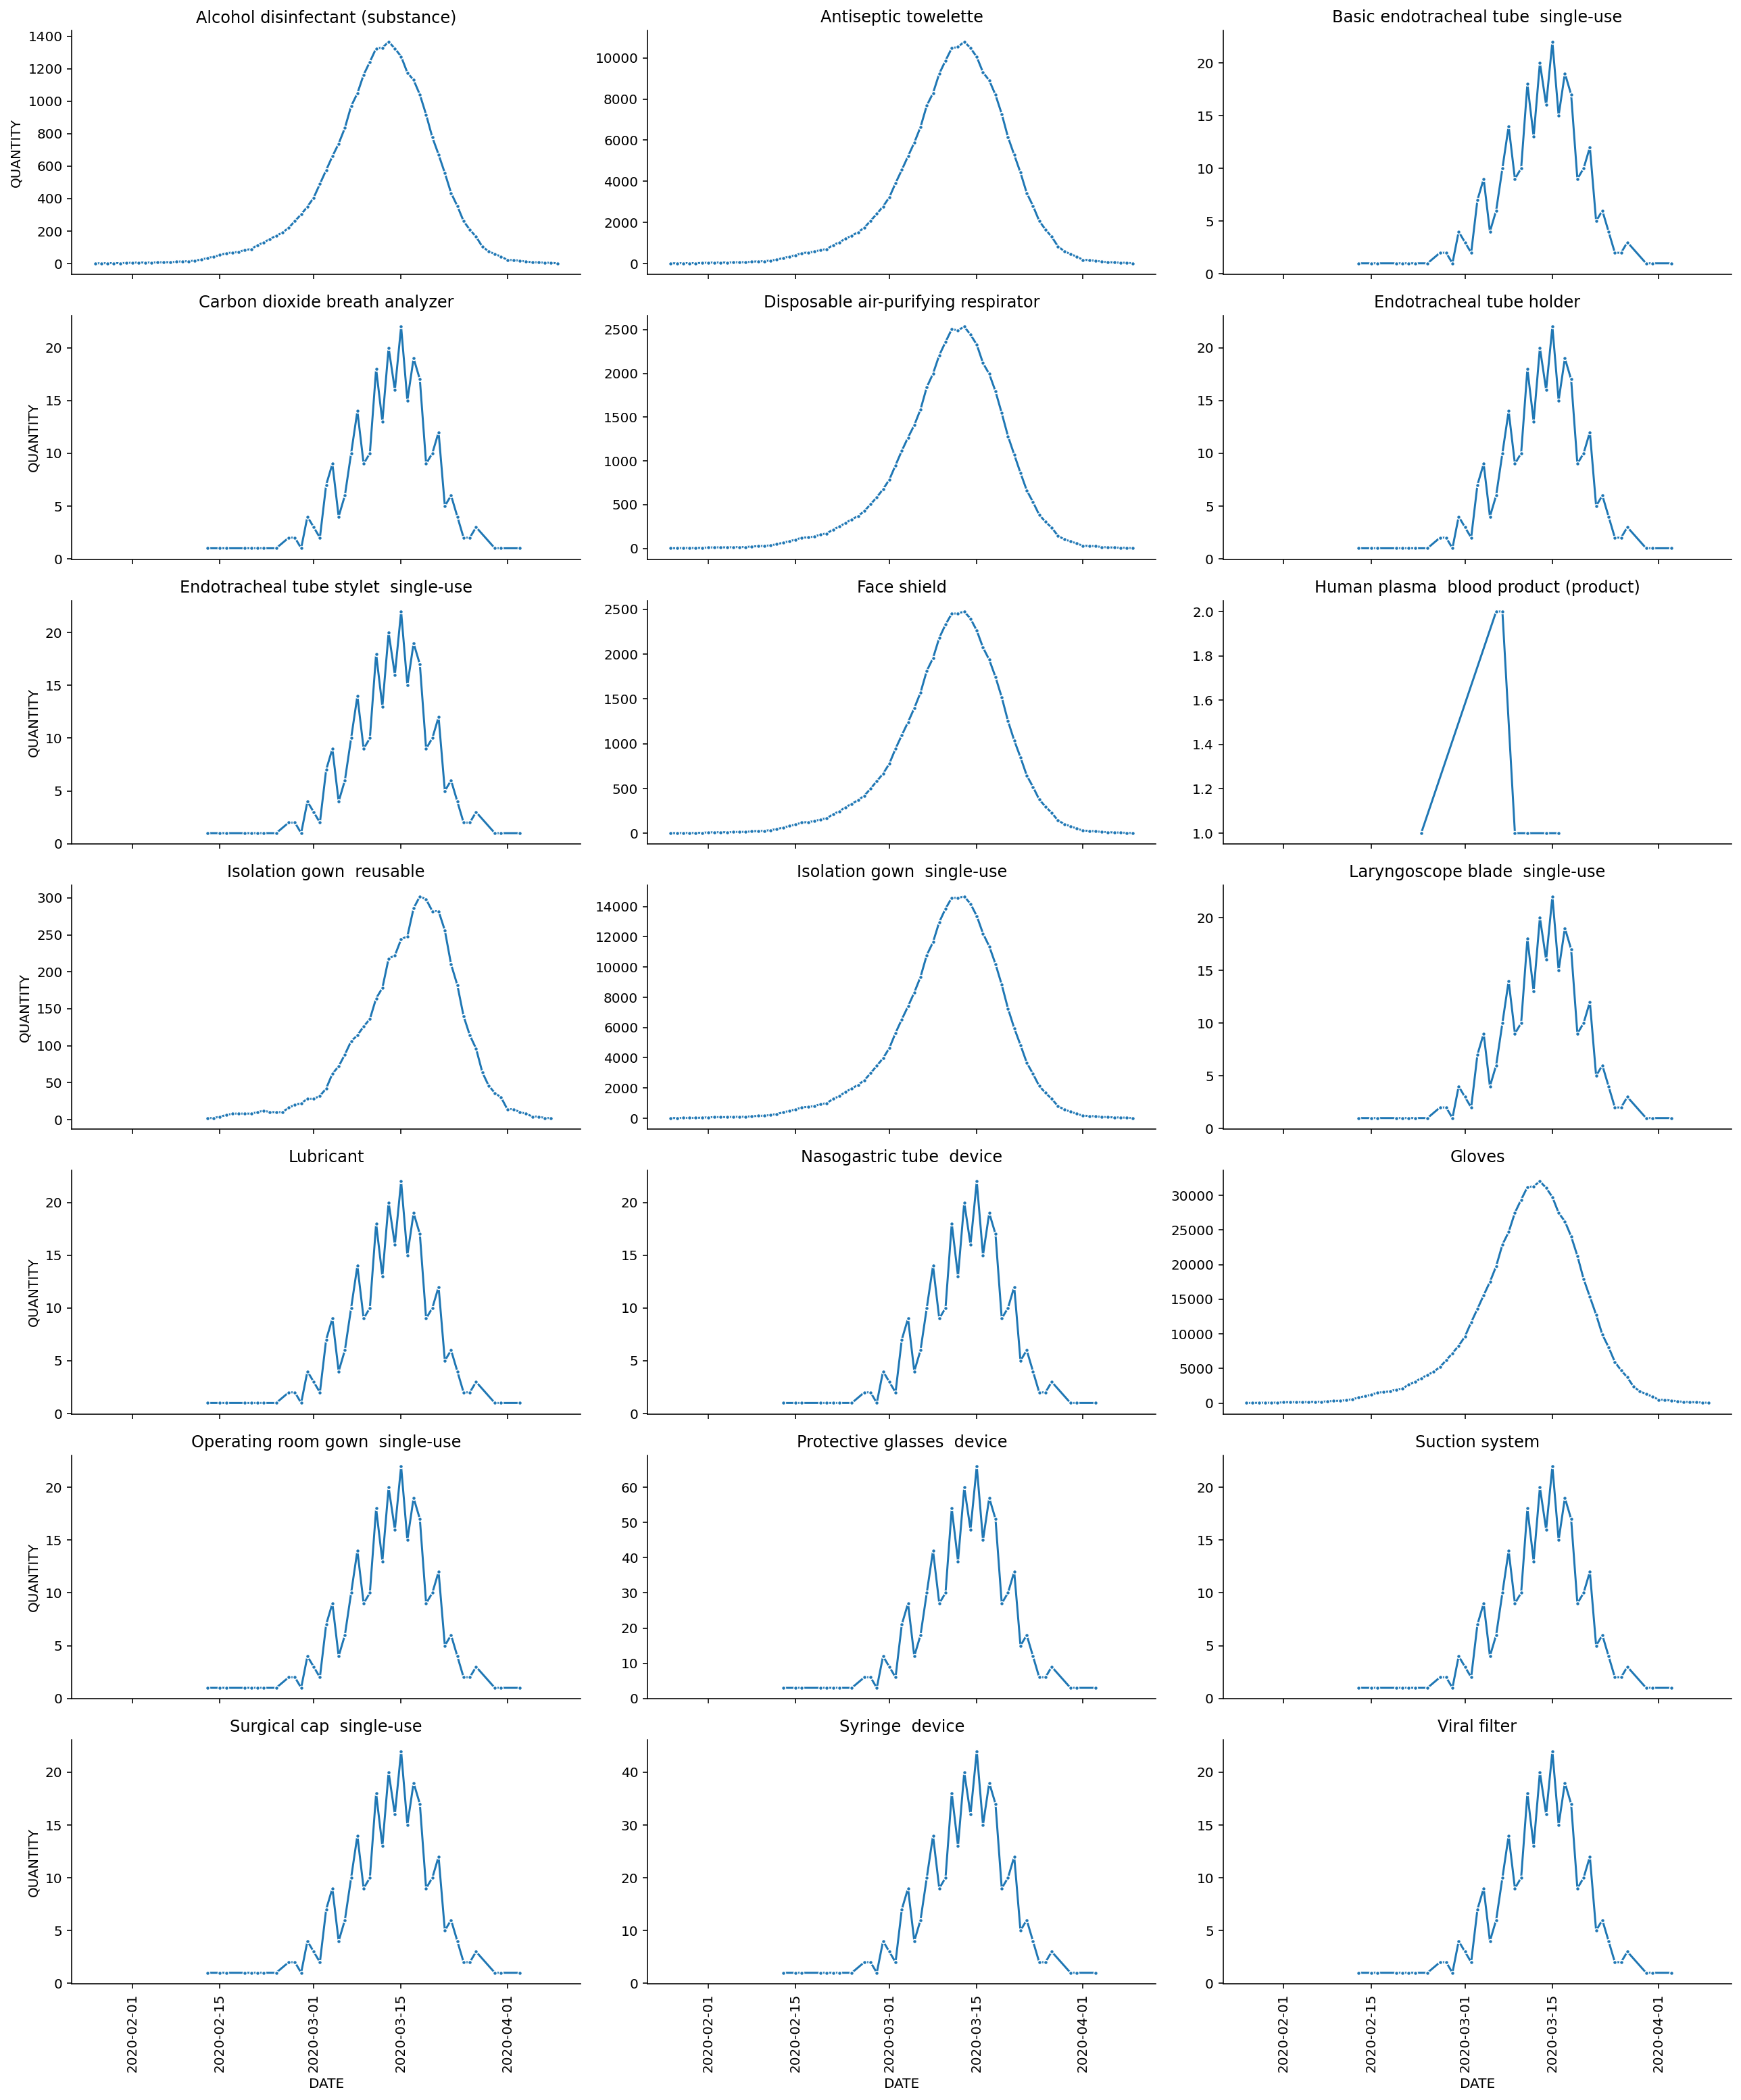

In [46]:
gs = grouped_supplies.reset_index()
gs['DATE'] = pd.to_datetime(gs.DATE)
g = sns.FacetGrid(gs, col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "DATE", "QUANTITY", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    if 'glove' in title:
        axes.set_title('Gloves')
    else:    
        axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)

In [47]:
supplies.groupby(['DESCRIPTION']).sum()[['QUANTITY']]

,QUANTITY
DESCRIPTION,
Alcohol disinfectant (substance),25337
Antiseptic towelette (physical object),200687
Basic endotracheal tube single-use (physical object),287
Carbon dioxide breath analyzer (physical object),287
Disposable air-purifying respirator (physical object),46015
Endotracheal tube holder (physical object),287
Endotracheal tube stylet single-use (physical object),287
Face shield (physical object),45154
Human plasma blood product (product),9


In [48]:
case_counts = conditions[conditions.CODE == 840539006].groupby('START').count()[['PATIENT']]
case_counts['total'] = case_counts['PATIENT'].cumsum()
case_counts = case_counts.rename(columns={'PATIENT': 'daily'})
case_counts = case_counts.reset_index()
case_counts['START'] = pd.to_datetime(case_counts.START)

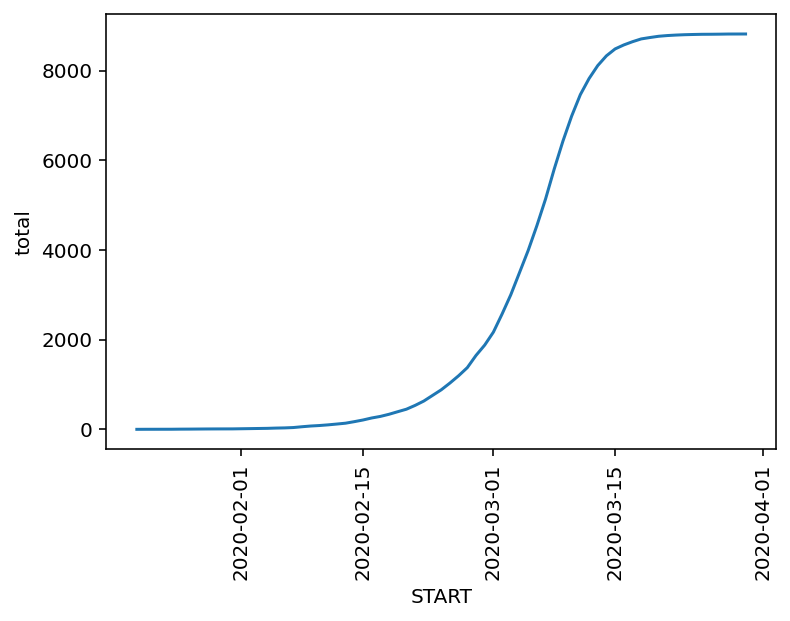

In [49]:
axes = sns.lineplot(x='START', y='total', data=case_counts)
plt.xticks(rotation=90)
plt.show()

In [50]:
covid_meds = medications[pd.to_datetime(medications.START) > pd.to_datetime('2020-01-20')]
covid_meds = covid_info.merge(covid_meds, on='PATIENT')

In [51]:
covid_meds.groupby(['DESCRIPTION']).sum()[['DISPENSES']].sort_values('DISPENSES', ascending=False).head(10)

,DISPENSES
DESCRIPTION,
Acetaminophen 500 MG Oral Tablet,3693
0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe,3610
1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe,2110
NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler,1819
1 ML Epoetin Alfa 4000 UNT/ML Injection [Epogen],794
Hydrochlorothiazide 25 MG Oral Tablet,719
insulin human isophane 70 UNT/ML / Regular Insulin Human 30 UNT/ML Injectable Suspension [Humulin],623
Simvastatin 10 MG Oral Tablet,591
amLODIPine 5 MG / Hydrochlorothiazide 12.5 MG / Olmesartan medoxomil 20 MG Oral Tablet,508


NameError: name 'analysis' is not defined

In [54]:
device_codes = [448907002, 449071006, 36965003]
grouped_dev = devices[devices.CODE.isin(device_codes)].groupby(['DESCRIPTION', 'START']).count()
grouped_dev = grouped_dev.reset_index()
grouped_dev['START'] = pd.to_datetime(grouped_dev.START)

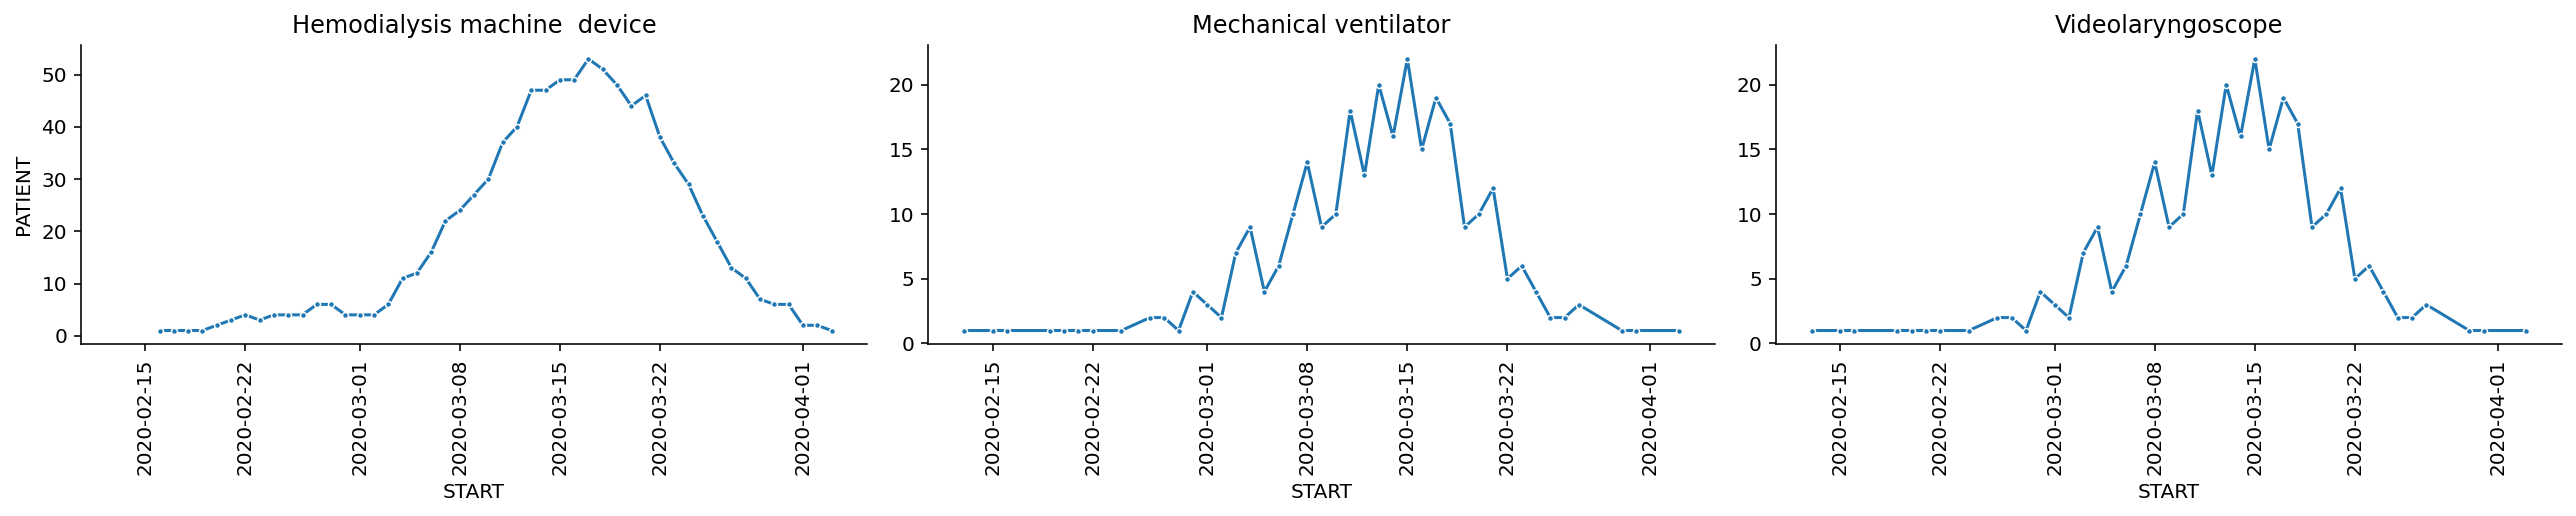

In [55]:
g = sns.FacetGrid(grouped_dev.reset_index(), col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "START", "PATIENT", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)